In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import os
import cv2
import random

import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#!ls /content/drive/My\ Drive


In [ ]:
!unzip /content/drive/MyDrive/Siamese_Network/Facesdata.zip

Archive:  /content/drive/MyDrive/Siamese_Network/Facesdata.zip
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (1).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (10).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (11).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (12).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (13).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (14).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (15).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (16).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_ (17).jpg  
  inflating: original_hp/10_hp_i made parasya maharta/10_hp_i made parasya maharta_

In [ ]:
# save img_path and labels into a dataframe
path = '/content/original_hp'
file_path = os.listdir(path)
img_paths = []
labels = []
count = 0
for file in file_path:
    img_path = [os.path.join(path,file,img_path) for img_path in os.listdir(os.path.join(path,file))]
    img_paths += img_path
    labels += [count]*len(img_path)
    count += 1

img_df = pd.DataFrame({'img_path':img_paths,
                     'labels':labels})
img_df.head()

,img_path,labels
0,/content/original_hp/hp-24-Wisswani/hp-24-wiss...,0
1,/content/original_hp/hp-24-Wisswani/hp-24-wiss...,0
2,/content/original_hp/hp-24-Wisswani/hp-24-wiss...,0
3,/content/original_hp/hp-24-Wisswani/hp-24-wiss...,0
4,/content/original_hp/hp-24-Wisswani/hp-24-wiss...,0


In [ ]:
# read sample img
random.seed(10)
sample_img = []
for i in img_df.labels.unique():
    sample_img_path = random.choice(list(img_df.loc[img_df.labels==i].img_path))
    sample_img.append(plt.imread(sample_img_path))

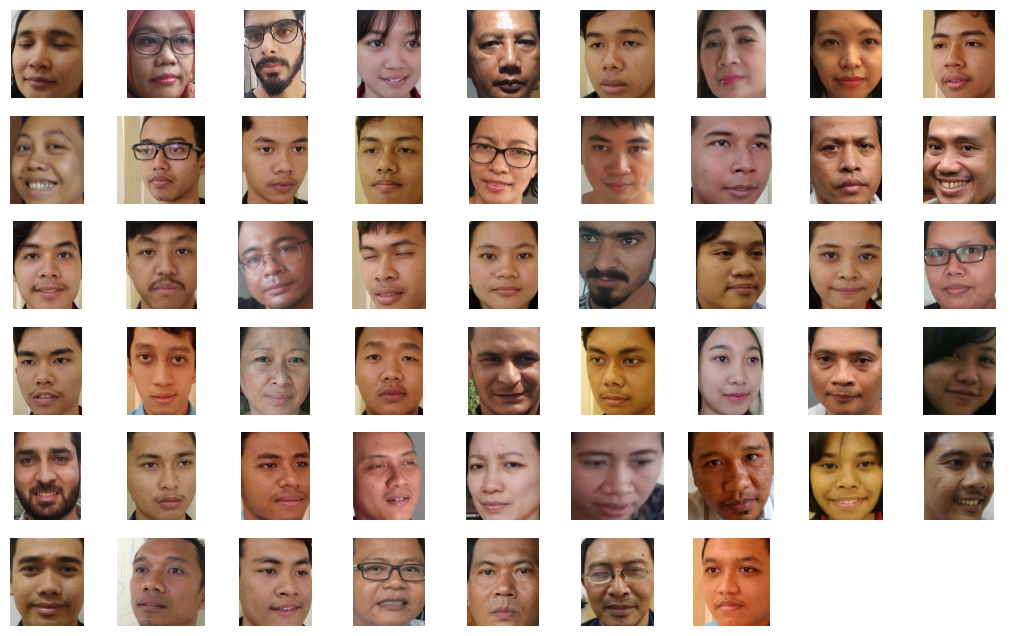

In [ ]:
# visualize sample img
fig, axs = plt.subplots(6,9,figsize=(13,8))
[ax.imshow(img) for img,ax in zip(sample_img,axs.ravel())]
[ax.axis('off') for ax in axs.ravel()];

In [ ]:
# Build Siamese Network, use pre-trained resnet in feature extraction
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork,self).__init__()
        self.feature_extraction = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.fc1 = nn.Linear(1000,1024)
        self.fc2 = nn.Linear(1024,512)
        self.dropout = nn.Dropout(p=.3)
        self.out = nn.Linear(512,2)
    def forward(self,x1, x2):
        out1 = self.feature_extraction(x1)
        out2 = self.feature_extraction(x2)
        dis = torch.abs(out1-out2)
        x = F.relu(self.fc1(dis))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.out(x)
        return out

In [ ]:
# test model and check output shape
model = SiameseNetwork()
x1,x2 = torch.tensor(np.random.randn(1,3,105,105)),torch.tensor(np.random.randn(1,3,105,105))
pred = model(x1.float(), x2.float())
pred.shape

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


torch.Size([1, 2])

In [ ]:
# build image transform function
def transforms_train():
    return A.Compose([
        A.ToGray(),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=.2, sat_shift_limit=.2, val_shift_limit=.2, p=.9),
            A.RandomBrightnessContrast(brightness_limit=.2, contrast_limit=.2, p=.9),
        ],p=.5),
        A.HorizontalFlip(),
        A.Resize(height=105,width=105,p=1)
    ])

def transforms_val():
    return A.Resize(height=105,width=105,p=1)

In [ ]:
# build dataset
class FaceDataset(Dataset):
    def __init__(self,img_df,test=False,transform=None):
        super(FaceDataset, self).__init__()
        self.img_df = img_df
        self.transform = transform
        self.num_classes = len(img_df.labels)
        self.test= test
    def __len__(self):
        # generate less sample if dataset is test set
        return 5000 if not self.test else 500
    def __getitem__(self, index):
        label = None
        img1 = None
        img2 = None
        # 50% anchor & positive, 50% anchor & negative
        if index % 2 == 1:
            # anchor & positive
            label = 1.0
            idx1 = random.choice(self.img_df.labels.unique())
            image1_path = random.choice(list(self.img_df.loc[self.img_df.labels==idx1].img_path))
            image2_path = random.choice(list(self.img_df.loc[self.img_df.labels==idx1].img_path))
        else:
            # anchor & negative
            label = 0.0
            idx1 = random.choice(self.img_df.labels.unique())
            idx2 = random.choice(self.img_df.labels.unique())
            while idx1 == idx2:
                # randomly select classes until it's different from anchor
                idx2 = random.choice(self.img_df.labels.unique())
            image1_path = random.choice(list(self.img_df.loc[self.img_df.labels==idx1].img_path))
            image2_path = random.choice(list(self.img_df.loc[self.img_df.labels==idx2].img_path))
        # read image
        image1 = cv2.imread(image1_path)[:,:,::-1].astype(np.float32)/255.
        image2 = cv2.imread(image2_path)[:,:,::-1].astype(np.float32)/255.

        if self.transform:
            # data augmentation
            image1 = self.transform(image=image1)['image']
            image2 = self.transform(image=image2)['image']

        # convert to tensor
        image1 = torch.as_tensor(np.transpose(image1.copy(),(2,0,1)), dtype=torch.float32)
        image2 = torch.as_tensor(np.transpose(image2.copy(),(2,0,1)), dtype=torch.float32)
        label = torch.as_tensor(np.array(label), dtype=torch.long)
        return image1, image2, label

In [ ]:
# Define a PyTorch Dataset class for handling face image pairs for a Siamese network
class FaceDataset(Dataset):
    def __init__(self, img_df, test=False, transform=None):
        super(FaceDataset, self).__init__()
        self.img_df = img_df  # DataFrame containing image paths and labels
        self.transform = transform  # Transformations to apply to images
        self.num_classes = len(img_df['labels'].unique())  # Number of unique classes in the dataset
        self.test = test  # Flag to determine if the dataset is for testing

    def __len__(self):
        # Determine number of samples to generate based on whether it is a test dataset
        return 5000 if not self.test else 500

    def __getitem__(self, index):
        # Generate one sample of data
        if index % 2 == 1:
            # Generate a pair of images from the same class (positive pair)
            idx1 = random.choice(self.img_df['labels'].unique())  # Randomly select a class
            paths = self.img_df[self.img_df['labels'] == idx1]['img_path']  # Filter paths by class
            image1_path, image2_path = random.sample(list(paths), 2)  # Randomly select two different images from the same class
            label = 1.0  # Assign a positive label
        else:
            # Generate a pair of images from different classes (negative pair)
            idx1, idx2 = random.sample(set(self.img_df['labels']), 2)  # Randomly select two different classes
            image1_path = random.choice(self.img_df[self.img_df['labels'] == idx1]['img_path'])  # Image from first class
            image2_path = random.choice(self.img_df[self.img_df['labels'] == idx2]['img_path'])  # Image from second class
            label = 0.0  # Assign a negative label

        # Load and preprocess images
        image1 = cv2.imread(image1_path)[:,:,::-1] / 255.  # Read image, convert BGR to RGB, normalize
        image2 = cv2.imread(image2_path)[:,:,::-1] / 255.  # Read image, convert BGR to RGB, normalize

        if self.transform:
            # Apply transformations if any
            image1 = self.transform(image=image1)['image']
            image2 = self.transform(image=image2)['image']

        # Convert images to PyTorch tensors
        image1 = torch.as_tensor(np.transpose(image1, (2, 0, 1)), dtype=torch.float32)  # Change data layout to CxHxW
        image2 = torch.as_tensor(np.transpose(image2, (2, 0, 1)), dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)  # Convert label to a PyTorch tensor

        return image1, image2, label


In [ ]:
# set parameter
BATCH_SIZE = 8
classes = img_df.labels.unique()
lr_rate = 2e-5
EPOCH = 10

In [ ]:
# split train and test set (test set will be completely different person)
img_train = img_df.loc[~img_df.labels.isin(classes[-5:])]
img_test = img_df.loc[img_df.labels.isin(classes[-5:])]
img_test.head()

,img_path,labels
1168,/content/original_hp/13_hp_narendra brillian a...,47
1169,/content/original_hp/13_hp_narendra brillian a...,47
1170,/content/original_hp/13_hp_narendra brillian a...,47
1171,/content/original_hp/13_hp_narendra brillian a...,47
1172,/content/original_hp/13_hp_narendra brillian a...,47


In [ ]:
# load dataset
train_dataset = FaceDataset(img_train,transform=transforms_train())
train_dataloader = DataLoader(train_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=True,
                       num_workers=2)
val_dataset = FaceDataset(img_test,test=True,transform=transforms_val())
val_dataloader = DataLoader(val_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=True,
                       num_workers=2)

In [ ]:
# visualize dataset
sample_data = next(iter(train_dataloader))
image = []
label = []
for i in range(5):
    image.append(sample_data[0][i].numpy())
    image.append(sample_data[1][i].numpy())
    label.append(sample_data[2][i].numpy())

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


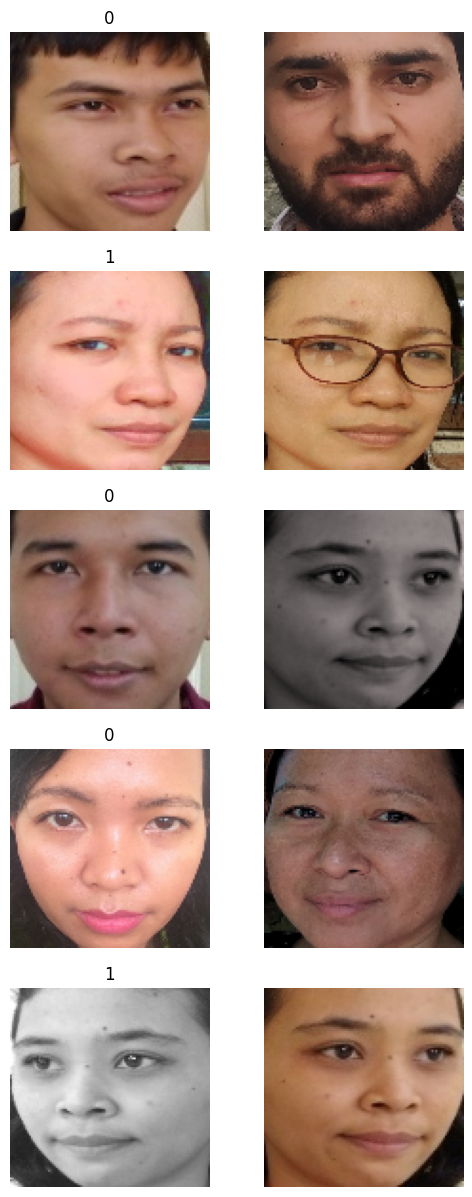

In [ ]:
# 0 represent anchor & negative, 1 represent anchor & positive
fig, axs = plt.subplots(5,2,figsize=(6,15))
[ax.imshow(np.transpose(img,(1,2,0))) for ax,img in zip(axs.ravel(), image)]
[ax.axis('off') for ax in axs.ravel()]
[ax.set_title(l) for ax,l in zip(axs.ravel()[::2],label)];

In [ ]:
# store accuracy and loss
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss,self.acc = 0,0
        self.sum_loss, self.sum_acc = 0,0
        self.avg_loss, self.avg_acc = 0,0
        self.sum = 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss = self.sum_loss / self.count
        self.avg_acc = self.sum_acc / self.count

In [ ]:
# calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

In [ ]:
device = torch.device('cuda')

def train_fn(data_loader, model, criterion, optimizer, device, epoch):
    model.train()
    criterion.train()

    # reset loss & accuracy
    summary_metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (image1, image2, label) in enumerate(tk0):
        image1 = image1.to(device).float()
        image2 = image2.to(device).float()
        labels = label.to(device).long()

        # make prediction
        outputs = model(image1, image2)
        # calculate loss
        loss = criterion(outputs, labels)

        # return class - 0,1
        preds = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        # calculate accuracy
        accuracy = check_acc(preds,labels)

        # update weight
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update loss & accuracy
        summary_metrics.update(loss,accuracy,BATCH_SIZE)
        tk0.set_postfix(loss=summary_metrics.avg_loss.item(),accuracy=summary_metrics.avg_acc,epoch=epoch+1)
    return summary_metrics

@torch.no_grad()
def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()

    # reset loss & accuracy
    summary_metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (image1, image2, label) in enumerate(tk0):
        image1 = image1.to(device).float()
        image2 = image2.to(device).float()
        labels = label.to(device).long()

        # make prediction
        outputs = model(image1, image2)
        # calculate loss
        loss = criterion(outputs, labels)

        # return class - 0,1
        preds = torch.argmax(torch.softmax(outputs, dim=1),dim=1)
        # calculate accuracy
        accuracy = check_acc(preds,labels)

        # update loss & accuracy
        summary_metrics.update(loss,accuracy,BATCH_SIZE)
        tk0.set_postfix(loss=summary_metrics.avg_loss.item(),accuracy=summary_metrics.avg_acc,epoch=epoch+1)
    return summary_metrics

In [ ]:
def run():
    # create model
    model = SiameseNetwork()
    # load weight if trained before
    if os.path.exists('./best.pth'):
        model.load_state_dict(torch.load('./best.pth'))
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()

    best_loss = 10**5
    for epoch in range(0,EPOCH):
        # train model
        train_loss = train_fn(train_dataloader, model, criterion, optimizer, device, epoch)
        val_loss = eval_fn(val_dataloader, model, criterion, device, epoch)
        scheduler.step(val_loss.avg_loss)
        if val_loss.avg_loss < best_loss:
            best_loss = val_loss.avg_loss
            torch.save(model.state_dict(),'best.pth')

In [ ]:
run()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
  0%|          | 0/625 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 623/625 [01:44<00:00,  5.25it/s, accuracy=0.597, epoch=1, loss=0.654]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 63/63 [00:04<00:00, 15.33it/s, accuracy=0.702, epoch=10, loss=0.901]


In [ ]:
# load best weight
model = SiameseNetwork()
model.load_state_dict(torch.load('./best.pth'))

In [ ]:
# get sample data from val_dataloader
sample_data = next(iter(val_dataloader))
image = []
label = []
for i in range(5):
    image.append(sample_data[0][i].numpy())
    image.append(sample_data[1][i].numpy())
    label.append(sample_data[2][i].numpy())

In [ ]:
# make prediction
outputs = model(sample_data[0],sample_data[1])
preds = torch.argmax(torch.softmax(outputs, dim=1),dim=1).numpy()
preds

In [ ]:
# visualize predication
fig, axs = plt.subplots(5,2,figsize=(6,15))
[ax.imshow(np.transpose(img,(1,2,0))) for ax,img in zip(axs.ravel(), image)]
[ax.axis('off') for ax in axs.ravel()]
[ax.set_title(f'Label:{l},Prediction:{p}') for ax,l,p in zip(axs.ravel()[::2],label,preds)];